# Forecasting TCN Model

---

## Imports
---

In [167]:
import torch.nn.functional as F
from torch import nn
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm
from torcheval.metrics import R2Score


# Device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu";

DEVICE

'cuda'

## Preparing Data
---

The input size will be of shape `(BATCH_SIZE, time_steps, temporal_feature_count)`. 
in our case this will be 32, 2 (this can change depending on how far we want to go in the future, for our dataset one time step is of 15 seconds) and 6 (hour, month and day of week (`sin` and `cosin`))

In [168]:

# Load data
df = pd.read_csv("./participant_data.csv")

# Drop unnecessary columns
df = df.drop(["agentID", "Altitude", "Longitude", "Latitude"], axis=1)
df = df.dropna(how='all')

# Convert '_time' to datetime and extract features
df['datetime'] = pd.to_datetime(df['_time'], errors='coerce')

df['hour_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour / 24)

df['dayOfWeek_sin'] = np.sin(2 * np.pi * df['datetime'].dt.day_of_week / 7)
df['dayOfWeek_cos'] = np.cos(2 * np.pi * df['datetime'].dt.day_of_week / 7)

df['month_sin'] = np.sin(2 * np.pi * df['datetime'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['datetime'].dt.month / 12)

# Drop the original time column and rows with NaN datetime
df = df.drop(["_time"], axis=1)
df = df.drop(["datetime"], axis=1)

# Fill NaN values with the median
columns_with_nan = df.columns[df.isnull().any()]
for column in columns_with_nan:
    median_value = df[column].median()  
    df[column] = df[column].fillna(median_value)  

# Convert non-numeric columns to numeric types
df = df.apply(pd.to_numeric, errors='coerce')

# Optionally save the cleaned DataFrame
df.to_csv("./new.csv", index=False)

# Convert to NumPy array and then to a PyTorch tensor
data = torch.from_numpy(df.to_numpy()).float()

# ============================== END DATA PREPROCESSING ============================== 

data.shape

torch.Size([1935, 10])

## Data Splitting
---

This will seperate the data into the corresponding shape.

In [169]:
def create_sequences(features, targets, input_steps, output_steps):
    X, y = [], []
    for i in range(len(features) - input_steps - output_steps + 1):
        X.append(features[i: i + input_steps])  
        y.append(targets[i + input_steps: i + input_steps + output_steps])  

    return np.array(X), np.array(y)

input_steps = 2;
output_steps = 2;

X, y = create_sequences(data[:, 4:], data[:, :4], input_steps, output_steps);

X.shape,y.shape

((1932, 2, 6), (1932, 2, 4))

Then, we simply have to split the data and labels into training and testing tensors and then put them into batched dataloaders.

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42);

X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE);
X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE);
y_train = torch.tensor(y_train, dtype=torch.float32).to(DEVICE);
y_test = torch.tensor(y_test, dtype=torch.float32).to(DEVICE);

BATCH_SIZE = 32;

train_dataset = TensorDataset(X_train, y_train);

train_dataloader = DataLoader(
    dataset=train_dataset, 
    shuffle=True,
    drop_last=True,
    batch_size=BATCH_SIZE
);

test_dataset = TensorDataset(X_test, y_test);

test_dataloader = DataLoader(
    dataset=test_dataset, 
    shuffle=False,
    drop_last=True,
    batch_size=BATCH_SIZE
);

next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape

(torch.Size([32, 2, 6]), torch.Size([32, 2, 4]))

## Define Model Architecture
---

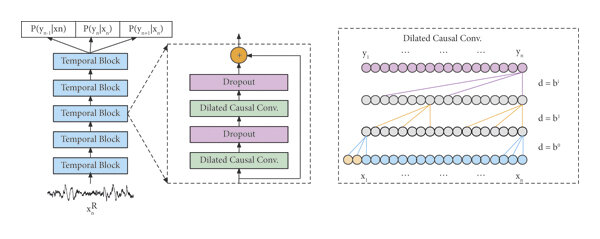

In [171]:

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernal_size, dilation, dropout) -> None:
        super(TemporalBlock, self).__init__();
        padding = (kernal_size - 1) * dilation;
    
        self.conv1 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernal_size,
            padding=padding,
            dilation=dilation
        );
    
        self.relu1 = nn.ReLU();
        self.dropout1 = nn.Dropout(dropout);
    
        self.conv2 = nn.Conv1d(
            dilation=dilation,
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernal_size,
            padding=padding
        );
    
        self.relu2 = nn.ReLU();
        self.dropout2 = nn.Dropout(dropout);

        # 1x1 convolution for residual connection if in_channels != out_channels
        self.downsample = nn.Conv1d(
            in_channels=in_channels,         # Number of input channels/features
            out_channels=out_channels,       # Number of output channels to match conv layers
            kernel_size=1                    # 1x1 convolution does not affect sequence length
        ) if in_channels != out_channels else None  # Only if input and output channels differ

    def forward(self, x):
        """
        Forward pass through the TemporalBlock.
        Args:
            x (Tensor): Input tensor of shape (batch_size, in_channels, sequence_length)
        Returns:
            Tensor: Output tensor of shape (batch_size, out_channels, adjusted_sequence_length)
        """

        # x shape: (B, in_channels, L_in)
        out = self.conv1(x)
        out = out[:, :, :-self.conv1.padding[0]]  # Remove extra padding for causality
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = out[:, :, :-self.conv2.padding[0]]  # Remove extra padding
        out = self.relu2(out)
        out = self.dropout2(out)

        # Residual connection
        res = x
        if self.downsample is not None:
            res = self.downsample(x);

        out = out + res[:, :, -out.size(2):]  # Adjust residual to match output length
        return out;


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, output_length, kernel_size=2, dropout=0.2) -> None:
        super(TCN, self).__init__();

        self.output_len = output_length;
        layers = [];
        num_levels = len(num_channels);

        for i in range(num_levels):
            dilation_size = 2 ** i; 
            in_channels = input_size if i == 0 else num_channels[i-1];
            out_channels = num_channels[i];

            layers.append(TemporalBlock(
                in_channels=in_channels,
                dilation=dilation_size,
                dropout=dropout,
                kernal_size=kernel_size,
                out_channels=out_channels,
            ));

        self.network = nn.Sequential(*layers);

        self.linear = nn.Linear(out_channels, output_size);

    def forward(self, x):
        """
        Forward pass through the TCN.
        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, input_size)
        Returns:
            Tensor: Output tensor of shape (batch_size, output_length, output_size)
        """

        # Transpose x to have shape (batch_size, input_size, sequence_length)
        x = x.transpose(1, 2)
        # Pass through the TCN network
        y = self.network(x) # Output shape: (batch_size, out_channels, adjusted_sequence_length) 
        # Transpose back to (batch_size, adjusted_sequence_length, out_channels) // in our case something like (32, 4, 64)
        y = y.transpose(1, 2)

        last_step = y[:, -1, :]  # Shape: (batch_size, out_channels)
        outputs = []
        current_input = last_step  # Shape: (batch_size, out_channels)
        for _ in range(self.output_len):
            out = self.linear(current_input)  # Shape: (batch_size, output_size)
            outputs.append(out.unsqueeze(1))  # Shape: (batch_size, 1, output_size)
            # Optionally, you can apply a nonlinear activation here if needed
            # current_input remains the same
        output = torch.cat(outputs, dim=1)  # Shape: (batch_size, output_length, output_size)
        return output



## Define a training function
---

In [172]:
def train_step(
    X: torch.Tensor, 
    y: torch.Tensor,     
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: torch.optim.Adam):
    
    X = X.to(DEVICE);
    y = y.to(DEVICE);
    model.to(DEVICE);
    model.train();

    # forward pass
    preds = model(X);

    # Calculate loss
    loss = loss_fn(preds, y);

    # reset gradients
    optimizer.zero_grad();

    # back prop
    loss.backward();

    # gradient desc
    optimizer.step();

    return (loss, preds);

## Define Testing function
---

In [173]:
def test_step(    
    X: torch.Tensor, 
    y: torch.Tensor,     
    model: nn.Module,
    loss_fn: nn.Module):
    
    X = X.to(DEVICE);
    y = y.to(DEVICE);
    model.to(DEVICE);
    
    # forward pass
    preds = model(X);

    # Calculate loss
    loss = loss_fn(preds, y);

    return (loss, preds);

## Putting both Together
---

In [174]:
def train(
    train_dataLoader: DataLoader, 
    test_dataLoader: DataLoader, 
    epochs: int,
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    metric: R2Score):
    """
    This method will train the given model.
    """
    model.to(DEVICE)  # Move model to DEVICE once, not in every batch

    for epoch in tqdm(range(epochs)):
        # Training phase
        model.train()
        total_train_loss = 0.0
        metric.reset()  # Reset metric at the beginning of each epoch

        for X, y in train_dataLoader:
            train_loss, preds = train_step(
                loss_fn=loss_fn,
                model=model,
                optimizer=optimizer,
                X=X,
                y=y,
            )
            seq_len = preds.shape[1]
            for t in range(seq_len):
                preds_t = preds[:, t, :]  # Shape: (batch_size, num_outputs)
                y_t = y[:, t, :]
                metric.update(preds_t, y_t)
            total_train_loss += train_loss.item()  # Accumulate loss

        # Compute average loss and R² for training
        avg_train_loss = total_train_loss / len(train_dataLoader)
        train_r2 = metric.compute().item()  # Get R² score

        # Validation phase
        model.eval()
        total_test_loss = 0.0
        metric.reset()  # Reset metric for validation

        with torch.inference_mode():        
            for X, y in test_dataLoader:
                test_loss, preds = test_step(
                    loss_fn=loss_fn,
                    model=model,
                    X=X,
                    y=y
                )
                seq_len = preds.shape[1]
                for t in range(seq_len):
                    preds_t = preds[:, t, :]  # Shape: (batch_size, num_outputs)
                    y_t = y[:, t, :]
                    metric.update(preds_t, y_t)

                total_test_loss += test_loss.item();

        # Compute average loss and R² for validation
        avg_test_loss = total_test_loss / len(test_dataLoader)
        test_r2 = metric.compute().item()

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"TRAINING LOSS : {avg_train_loss:.4f} | TRAINING R² : {train_r2:.4f}")
        print(f"VALIDATION LOSS : {avg_test_loss:.4f} | VALIDATION R² : {test_r2:.4f}\n")

## Instantiate the model
---

In [175]:


output_size = 4;
input_size = 6;
num_channels = [16,32];
time_steps = 2; # will predict 2 steps into the future.
kernal_size = 3;

model = TCN( 
    output_size=output_size,
    input_size=input_size,
    num_channels=num_channels,
    output_length=time_steps,
    kernel_size=kernal_size
).to(DEVICE);

model
    

TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(2,))
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (downsample): Conv1d(6, 16, kernel_size=(1,), stride=(1,))
    )
    (1): TemporalBlock(
      (conv1): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (downsample): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (linear): Linear(in_features=32, out_features=4, bias=True)
)

## Find Loss Function and Optimizer
---

In [176]:
loss_fn = nn.MSELoss();
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.0001
);

## Train Model !
---

In [177]:
train(
    epochs=100,
    loss_fn=loss_fn,
    model=model.to(DEVICE),
    optimizer=optimizer,
    test_dataLoader=test_dataloader,
    train_dataLoader=train_dataloader,
    metric=R2Score()
);

  1%|          | 1/100 [00:00<00:30,  3.26it/s]

Epoch 1/100
TRAINING LOSS : 1098817882.0501 | TRAINING R² : -0.3590
VALIDATION LOSS : 5387.6733 | VALIDATION R² : -0.8971



  2%|▏         | 2/100 [00:00<00:26,  3.69it/s]

Epoch 2/100
TRAINING LOSS : 1098817695.3715 | TRAINING R² : -0.3591
VALIDATION LOSS : 5384.4379 | VALIDATION R² : -0.8959



  3%|▎         | 3/100 [00:00<00:24,  3.89it/s]

Epoch 3/100
TRAINING LOSS : 1098817827.9731 | TRAINING R² : -0.3582
VALIDATION LOSS : 5381.1421 | VALIDATION R² : -0.8947



  4%|▍         | 4/100 [00:01<00:25,  3.82it/s]

Epoch 4/100
TRAINING LOSS : 1098817841.8279 | TRAINING R² : -0.3569
VALIDATION LOSS : 5376.9236 | VALIDATION R² : -0.8931



  5%|▌         | 5/100 [00:01<00:24,  3.93it/s]

Epoch 5/100
TRAINING LOSS : 1098817661.8407 | TRAINING R² : -0.3557
VALIDATION LOSS : 5373.2894 | VALIDATION R² : -0.8917



  6%|▌         | 6/100 [00:01<00:23,  3.96it/s]

Epoch 6/100
TRAINING LOSS : 1098817647.2303 | TRAINING R² : -0.3551
VALIDATION LOSS : 5368.8462 | VALIDATION R² : -0.8901



  7%|▋         | 7/100 [00:01<00:22,  4.08it/s]

Epoch 7/100
TRAINING LOSS : 549412657.3371 | TRAINING R² : -0.3539
VALIDATION LOSS : 5364.8236 | VALIDATION R² : -0.8886



  8%|▊         | 8/100 [00:02<00:22,  4.16it/s]

Epoch 8/100
TRAINING LOSS : 1098817563.6389 | TRAINING R² : -0.3531
VALIDATION LOSS : 5360.0911 | VALIDATION R² : -0.8868



  9%|▉         | 9/100 [00:02<00:22,  4.10it/s]

Epoch 9/100
TRAINING LOSS : 1098817438.1926 | TRAINING R² : -0.3517
VALIDATION LOSS : 5355.7691 | VALIDATION R² : -0.8852



 10%|█         | 10/100 [00:02<00:21,  4.15it/s]

Epoch 10/100
TRAINING LOSS : 1098817411.0571 | TRAINING R² : -0.3506
VALIDATION LOSS : 5350.2421 | VALIDATION R² : -0.8831



 11%|█         | 11/100 [00:02<00:21,  4.15it/s]

Epoch 11/100
TRAINING LOSS : 1098817325.0212 | TRAINING R² : -0.3494
VALIDATION LOSS : 5344.7533 | VALIDATION R² : -0.8810



 12%|█▏        | 12/100 [00:02<00:20,  4.21it/s]

Epoch 12/100
TRAINING LOSS : 1098817276.3379 | TRAINING R² : -0.3482
VALIDATION LOSS : 5338.4576 | VALIDATION R² : -0.8786



 13%|█▎        | 13/100 [00:03<00:20,  4.25it/s]

Epoch 13/100
TRAINING LOSS : 1098817215.0766 | TRAINING R² : -0.3463
VALIDATION LOSS : 5334.4715 | VALIDATION R² : -0.8771



 14%|█▍        | 14/100 [00:03<00:19,  4.30it/s]

Epoch 14/100
TRAINING LOSS : 1098817116.1144 | TRAINING R² : -0.3450
VALIDATION LOSS : 5325.6098 | VALIDATION R² : -0.8738



 15%|█▌        | 15/100 [00:03<00:19,  4.28it/s]

Epoch 15/100
TRAINING LOSS : 1098817096.4324 | TRAINING R² : -0.3440
VALIDATION LOSS : 5319.3789 | VALIDATION R² : -0.8715



 16%|█▌        | 16/100 [00:03<00:20,  4.19it/s]

Epoch 16/100
TRAINING LOSS : 1098816311.5153 | TRAINING R² : -0.3409
VALIDATION LOSS : 5309.7230 | VALIDATION R² : -0.8678



 17%|█▋        | 17/100 [00:04<00:19,  4.18it/s]

Epoch 17/100
TRAINING LOSS : 1098816772.7146 | TRAINING R² : -0.3386
VALIDATION LOSS : 5300.8241 | VALIDATION R² : -0.8644



 18%|█▊        | 18/100 [00:04<00:19,  4.22it/s]

Epoch 18/100
TRAINING LOSS : 1098816669.4769 | TRAINING R² : -0.3373
VALIDATION LOSS : 5291.6845 | VALIDATION R² : -0.8610



 19%|█▉        | 19/100 [00:04<00:19,  4.15it/s]

Epoch 19/100
TRAINING LOSS : 1098816629.5834 | TRAINING R² : -0.3395
VALIDATION LOSS : 5281.1312 | VALIDATION R² : -0.8571



 20%|██        | 20/100 [00:04<00:18,  4.24it/s]

Epoch 20/100
TRAINING LOSS : 1098816527.3716 | TRAINING R² : -0.3304
VALIDATION LOSS : 5269.8759 | VALIDATION R² : -0.8528



 21%|██        | 21/100 [00:05<00:18,  4.29it/s]

Epoch 21/100
TRAINING LOSS : 1098816475.9359 | TRAINING R² : -0.3276
VALIDATION LOSS : 5255.9500 | VALIDATION R² : -0.8476



 22%|██▏       | 22/100 [00:05<00:17,  4.34it/s]

Epoch 22/100
TRAINING LOSS : 1098815999.3806 | TRAINING R² : -0.3242
VALIDATION LOSS : 5243.3122 | VALIDATION R² : -0.8429



 23%|██▎       | 23/100 [00:05<00:17,  4.33it/s]

Epoch 23/100
TRAINING LOSS : 1098815849.6953 | TRAINING R² : -0.3201
VALIDATION LOSS : 5224.7190 | VALIDATION R² : -0.8359



 24%|██▍       | 24/100 [00:05<00:17,  4.35it/s]

Epoch 24/100
TRAINING LOSS : 1098816017.7576 | TRAINING R² : -0.3152
VALIDATION LOSS : 5206.8789 | VALIDATION R² : -0.8292



 25%|██▌       | 25/100 [00:06<00:17,  4.29it/s]

Epoch 25/100
TRAINING LOSS : 1098815538.3636 | TRAINING R² : -0.3104
VALIDATION LOSS : 5190.6932 | VALIDATION R² : -0.8232



 26%|██▌       | 26/100 [00:06<00:17,  4.32it/s]

Epoch 26/100
TRAINING LOSS : 1098815408.8476 | TRAINING R² : -0.3043
VALIDATION LOSS : 5165.9580 | VALIDATION R² : -0.8138



 27%|██▋       | 27/100 [00:06<00:16,  4.31it/s]

Epoch 27/100
TRAINING LOSS : 1098815410.7631 | TRAINING R² : -0.2989
VALIDATION LOSS : 5144.0044 | VALIDATION R² : -0.8055



 28%|██▊       | 28/100 [00:06<00:16,  4.35it/s]

Epoch 28/100
TRAINING LOSS : 1098815084.2986 | TRAINING R² : -0.2914
VALIDATION LOSS : 5116.8554 | VALIDATION R² : -0.7954



 29%|██▉       | 29/100 [00:06<00:16,  4.31it/s]

Epoch 29/100
TRAINING LOSS : 1098814661.6837 | TRAINING R² : -0.3063
VALIDATION LOSS : 5095.6889 | VALIDATION R² : -0.7875



 30%|███       | 30/100 [00:07<00:16,  4.29it/s]

Epoch 30/100
TRAINING LOSS : 1098814519.9939 | TRAINING R² : -0.2767
VALIDATION LOSS : 5061.6842 | VALIDATION R² : -0.7748



 31%|███       | 31/100 [00:07<00:16,  4.31it/s]

Epoch 31/100
TRAINING LOSS : 1098814166.0797 | TRAINING R² : -0.2695
VALIDATION LOSS : 5037.9258 | VALIDATION R² : -0.7660



 32%|███▏      | 32/100 [00:07<00:15,  4.33it/s]

Epoch 32/100
TRAINING LOSS : 1098813593.2781 | TRAINING R² : -0.2592
VALIDATION LOSS : 5000.5118 | VALIDATION R² : -0.7520



 33%|███▎      | 33/100 [00:07<00:15,  4.27it/s]

Epoch 33/100
TRAINING LOSS : 549410130.3828 | TRAINING R² : -0.2716
VALIDATION LOSS : 4977.3236 | VALIDATION R² : -0.7434



 34%|███▍      | 34/100 [00:08<00:15,  4.28it/s]

Epoch 34/100
TRAINING LOSS : 1098812925.2294 | TRAINING R² : -0.2439
VALIDATION LOSS : 4945.8566 | VALIDATION R² : -0.7317



 35%|███▌      | 35/100 [00:08<00:15,  4.31it/s]

Epoch 35/100
TRAINING LOSS : 1098813023.4673 | TRAINING R² : -0.2329
VALIDATION LOSS : 4904.5376 | VALIDATION R² : -0.7163



 36%|███▌      | 36/100 [00:08<00:14,  4.30it/s]

Epoch 36/100
TRAINING LOSS : 1098812053.1807 | TRAINING R² : -0.2428
VALIDATION LOSS : 4874.9810 | VALIDATION R² : -0.7053



 37%|███▋      | 37/100 [00:08<00:14,  4.28it/s]

Epoch 37/100
TRAINING LOSS : 1098812826.6678 | TRAINING R² : -0.2105
VALIDATION LOSS : 4829.1723 | VALIDATION R² : -0.6883



 38%|███▊      | 38/100 [00:09<00:14,  4.33it/s]

Epoch 38/100
TRAINING LOSS : 1098810842.7952 | TRAINING R² : -0.2001
VALIDATION LOSS : 4785.8096 | VALIDATION R² : -0.6721



 39%|███▉      | 39/100 [00:09<00:14,  4.33it/s]

Epoch 39/100
TRAINING LOSS : 1098811087.9757 | TRAINING R² : -0.2034
VALIDATION LOSS : 4745.4744 | VALIDATION R² : -0.6571



 40%|████      | 40/100 [00:09<00:13,  4.37it/s]

Epoch 40/100
TRAINING LOSS : 1098809866.1441 | TRAINING R² : -0.1773
VALIDATION LOSS : 4695.8318 | VALIDATION R² : -0.6385



 41%|████      | 41/100 [00:09<00:13,  4.31it/s]

Epoch 41/100
TRAINING LOSS : 1098809742.1599 | TRAINING R² : -0.1608
VALIDATION LOSS : 4631.3201 | VALIDATION R² : -0.6143



 42%|████▏     | 42/100 [00:09<00:14,  4.08it/s]

Epoch 42/100
TRAINING LOSS : 1098808388.4720 | TRAINING R² : -0.1483
VALIDATION LOSS : 4574.6667 | VALIDATION R² : -0.5931



 43%|████▎     | 43/100 [00:10<00:13,  4.13it/s]

Epoch 43/100
TRAINING LOSS : 1098808814.6762 | TRAINING R² : -0.1293
VALIDATION LOSS : 4519.3728 | VALIDATION R² : -0.5724



 44%|████▍     | 44/100 [00:10<00:13,  4.10it/s]

Epoch 44/100
TRAINING LOSS : 1098807621.1762 | TRAINING R² : -0.1181
VALIDATION LOSS : 4468.5416 | VALIDATION R² : -0.5532



 45%|████▌     | 45/100 [00:10<00:13,  4.16it/s]

Epoch 45/100
TRAINING LOSS : 1098807078.8518 | TRAINING R² : -0.1058
VALIDATION LOSS : 4427.2855 | VALIDATION R² : -0.5378



 46%|████▌     | 46/100 [00:10<00:12,  4.25it/s]

Epoch 46/100
TRAINING LOSS : 1098805126.2254 | TRAINING R² : -0.0960
VALIDATION LOSS : 4371.1540 | VALIDATION R² : -0.5165



 47%|████▋     | 47/100 [00:11<00:12,  4.30it/s]

Epoch 47/100
TRAINING LOSS : 1098803564.9891 | TRAINING R² : -0.0822
VALIDATION LOSS : 4321.3823 | VALIDATION R² : -0.4976



 48%|████▊     | 48/100 [00:11<00:11,  4.35it/s]

Epoch 48/100
TRAINING LOSS : 1098804726.3477 | TRAINING R² : -0.0729
VALIDATION LOSS : 4266.1929 | VALIDATION R² : -0.4766



 49%|████▉     | 49/100 [00:11<00:11,  4.40it/s]

Epoch 49/100
TRAINING LOSS : 1098800164.0996 | TRAINING R² : -0.0583
VALIDATION LOSS : 4194.0701 | VALIDATION R² : -0.4488



 50%|█████     | 50/100 [00:11<00:11,  4.39it/s]

Epoch 50/100
TRAINING LOSS : 1098802174.2989 | TRAINING R² : -0.0476
VALIDATION LOSS : 4144.3302 | VALIDATION R² : -0.4295



 51%|█████     | 51/100 [00:12<00:11,  4.32it/s]

Epoch 51/100
TRAINING LOSS : 1098798799.2988 | TRAINING R² : -0.0409
VALIDATION LOSS : 4103.4284 | VALIDATION R² : -0.4136



 52%|█████▏    | 52/100 [00:12<00:11,  4.34it/s]

Epoch 52/100
TRAINING LOSS : 1098802503.3866 | TRAINING R² : -0.0345
VALIDATION LOSS : 4060.7257 | VALIDATION R² : -0.3969



 53%|█████▎    | 53/100 [00:12<00:10,  4.37it/s]

Epoch 53/100
TRAINING LOSS : 1098800023.7999 | TRAINING R² : -0.0316
VALIDATION LOSS : 4009.2183 | VALIDATION R² : -0.3764



 54%|█████▍    | 54/100 [00:12<00:10,  4.36it/s]

Epoch 54/100
TRAINING LOSS : 1098795281.1694 | TRAINING R² : -0.0212
VALIDATION LOSS : 3968.0374 | VALIDATION R² : -0.3598



 55%|█████▌    | 55/100 [00:13<00:10,  4.17it/s]

Epoch 55/100
TRAINING LOSS : 1098796866.7438 | TRAINING R² : -0.0256
VALIDATION LOSS : 3930.2936 | VALIDATION R² : -0.3444



 56%|█████▌    | 56/100 [00:13<00:10,  4.23it/s]

Epoch 56/100
TRAINING LOSS : 1098793855.9751 | TRAINING R² : -0.0232
VALIDATION LOSS : 3895.3894 | VALIDATION R² : -0.3299



 57%|█████▋    | 57/100 [00:13<00:10,  4.26it/s]

Epoch 57/100
TRAINING LOSS : 1098793468.6389 | TRAINING R² : -0.0224
VALIDATION LOSS : 3864.2296 | VALIDATION R² : -0.3169



 58%|█████▊    | 58/100 [00:13<00:10,  4.18it/s]

Epoch 58/100
TRAINING LOSS : 1098787809.1651 | TRAINING R² : -0.0276
VALIDATION LOSS : 3837.1953 | VALIDATION R² : -0.3054



 59%|█████▉    | 59/100 [00:13<00:09,  4.17it/s]

Epoch 59/100
TRAINING LOSS : 1098788323.2018 | TRAINING R² : -0.0268
VALIDATION LOSS : 3807.6389 | VALIDATION R² : -0.2926



 60%|██████    | 60/100 [00:14<00:09,  4.01it/s]

Epoch 60/100
TRAINING LOSS : 1098788596.5633 | TRAINING R² : -0.0334
VALIDATION LOSS : 3782.2636 | VALIDATION R² : -0.2817



 61%|██████    | 61/100 [00:14<00:09,  4.14it/s]

Epoch 61/100
TRAINING LOSS : 1098786859.5721 | TRAINING R² : -0.0358
VALIDATION LOSS : 3751.2937 | VALIDATION R² : -0.2682



 62%|██████▏   | 62/100 [00:14<00:09,  4.19it/s]

Epoch 62/100
TRAINING LOSS : 1096742329.4738 | TRAINING R² : -0.0423
VALIDATION LOSS : 3722.9068 | VALIDATION R² : -0.2559



 63%|██████▎   | 63/100 [00:14<00:08,  4.16it/s]

Epoch 63/100
TRAINING LOSS : 549395749.7356 | TRAINING R² : -0.0459
VALIDATION LOSS : 3703.6657 | VALIDATION R² : -0.2481



 64%|██████▍   | 64/100 [00:15<00:08,  4.15it/s]

Epoch 64/100
TRAINING LOSS : 1098779893.9717 | TRAINING R² : -0.0508
VALIDATION LOSS : 3675.9947 | VALIDATION R² : -0.2363



 65%|██████▌   | 65/100 [00:15<00:08,  4.23it/s]

Epoch 65/100
TRAINING LOSS : 1098780450.9781 | TRAINING R² : -0.0447
VALIDATION LOSS : 3655.5464 | VALIDATION R² : -0.2280



 66%|██████▌   | 66/100 [00:15<00:07,  4.26it/s]

Epoch 66/100
TRAINING LOSS : 1098780299.6229 | TRAINING R² : -0.0545
VALIDATION LOSS : 3625.9623 | VALIDATION R² : -0.2152



 67%|██████▋   | 67/100 [00:15<00:07,  4.22it/s]

Epoch 67/100
TRAINING LOSS : 1098782026.3421 | TRAINING R² : -0.0529
VALIDATION LOSS : 3595.1478 | VALIDATION R² : -0.2022



 68%|██████▊   | 68/100 [00:16<00:07,  4.10it/s]

Epoch 68/100
TRAINING LOSS : 1098768213.9509 | TRAINING R² : -0.0658
VALIDATION LOSS : 3563.1253 | VALIDATION R² : -0.1888



 69%|██████▉   | 69/100 [00:16<00:07,  4.14it/s]

Epoch 69/100
TRAINING LOSS : 1098769784.9621 | TRAINING R² : -0.0515
VALIDATION LOSS : 3539.1815 | VALIDATION R² : -0.1795



 70%|███████   | 70/100 [00:16<00:07,  4.14it/s]

Epoch 70/100
TRAINING LOSS : 1098766912.8903 | TRAINING R² : -0.0599
VALIDATION LOSS : 3509.1477 | VALIDATION R² : -0.1670



 71%|███████   | 71/100 [00:16<00:06,  4.15it/s]

Epoch 71/100
TRAINING LOSS : 1098769116.7935 | TRAINING R² : -0.0672
VALIDATION LOSS : 3478.5367 | VALIDATION R² : -0.1541



 72%|███████▏  | 72/100 [00:17<00:06,  4.13it/s]

Epoch 72/100
TRAINING LOSS : 549386709.9294 | TRAINING R² : -0.0654
VALIDATION LOSS : 3455.1700 | VALIDATION R² : -0.1456



 73%|███████▎  | 73/100 [00:17<00:06,  4.21it/s]

Epoch 73/100
TRAINING LOSS : 1098767242.9777 | TRAINING R² : -0.0598
VALIDATION LOSS : 3431.3782 | VALIDATION R² : -0.1363



 74%|███████▍  | 74/100 [00:17<00:06,  4.26it/s]

Epoch 74/100
TRAINING LOSS : 1098756429.5429 | TRAINING R² : -0.0661
VALIDATION LOSS : 3405.3040 | VALIDATION R² : -0.1255



 75%|███████▌  | 75/100 [00:17<00:05,  4.20it/s]

Epoch 75/100
TRAINING LOSS : 1098750749.0191 | TRAINING R² : -0.0618
VALIDATION LOSS : 3380.6801 | VALIDATION R² : -0.1155



 76%|███████▌  | 76/100 [00:18<00:05,  4.21it/s]

Epoch 76/100
TRAINING LOSS : 1098752977.6967 | TRAINING R² : -0.0572
VALIDATION LOSS : 3360.7593 | VALIDATION R² : -0.1078



 77%|███████▋  | 77/100 [00:18<00:05,  4.21it/s]

Epoch 77/100
TRAINING LOSS : 1098743067.8915 | TRAINING R² : -0.0668
VALIDATION LOSS : 3340.2763 | VALIDATION R² : -0.1003



 78%|███████▊  | 78/100 [00:18<00:05,  4.14it/s]

Epoch 78/100
TRAINING LOSS : 1098749345.7866 | TRAINING R² : -0.0628
VALIDATION LOSS : 3324.6399 | VALIDATION R² : -0.0939



 79%|███████▉  | 79/100 [00:18<00:05,  4.16it/s]

Epoch 79/100
TRAINING LOSS : 1098728060.6873 | TRAINING R² : -0.0717
VALIDATION LOSS : 3311.1264 | VALIDATION R² : -0.0890



 80%|████████  | 80/100 [00:19<00:04,  4.14it/s]

Epoch 80/100
TRAINING LOSS : 1098756223.9953 | TRAINING R² : -0.0643
VALIDATION LOSS : 3296.7770 | VALIDATION R² : -0.0842



 81%|████████  | 81/100 [00:19<00:04,  4.19it/s]

Epoch 81/100
TRAINING LOSS : 1098739985.7958 | TRAINING R² : -0.0643
VALIDATION LOSS : 3285.0391 | VALIDATION R² : -0.0805



 82%|████████▏ | 82/100 [00:19<00:04,  4.29it/s]

Epoch 82/100
TRAINING LOSS : 1098727684.8312 | TRAINING R² : -0.0551
VALIDATION LOSS : 3290.4256 | VALIDATION R² : -0.0831



 83%|████████▎ | 83/100 [00:19<00:03,  4.34it/s]

Epoch 83/100
TRAINING LOSS : 1098716014.3779 | TRAINING R² : -0.0562
VALIDATION LOSS : 3293.3312 | VALIDATION R² : -0.0852



 84%|████████▍ | 84/100 [00:19<00:03,  4.39it/s]

Epoch 84/100
TRAINING LOSS : 1098717159.1005 | TRAINING R² : -0.0596
VALIDATION LOSS : 3309.6153 | VALIDATION R² : -0.0926



 85%|████████▌ | 85/100 [00:20<00:03,  4.32it/s]

Epoch 85/100
TRAINING LOSS : 1098723740.3947 | TRAINING R² : -0.0582
VALIDATION LOSS : 3315.3957 | VALIDATION R² : -0.0960



 86%|████████▌ | 86/100 [00:20<00:03,  4.33it/s]

Epoch 86/100
TRAINING LOSS : 1098709495.2261 | TRAINING R² : -0.0546
VALIDATION LOSS : 3344.3869 | VALIDATION R² : -0.1088



 87%|████████▋ | 87/100 [00:20<00:03,  4.30it/s]

Epoch 87/100
TRAINING LOSS : 1098704663.9461 | TRAINING R² : -0.0534
VALIDATION LOSS : 3374.7932 | VALIDATION R² : -0.1220



 88%|████████▊ | 88/100 [00:20<00:02,  4.26it/s]

Epoch 88/100
TRAINING LOSS : 1098720972.6348 | TRAINING R² : -0.0522
VALIDATION LOSS : 3400.1422 | VALIDATION R² : -0.1333



 89%|████████▉ | 89/100 [00:21<00:02,  4.05it/s]

Epoch 89/100
TRAINING LOSS : 1098724123.0237 | TRAINING R² : -0.0546
VALIDATION LOSS : 3436.8086 | VALIDATION R² : -0.1492



 90%|█████████ | 90/100 [00:21<00:02,  4.12it/s]

Epoch 90/100
TRAINING LOSS : 1098695172.7963 | TRAINING R² : -0.0566
VALIDATION LOSS : 3491.5715 | VALIDATION R² : -0.1725



 91%|█████████ | 91/100 [00:21<00:02,  4.20it/s]

Epoch 91/100
TRAINING LOSS : 1098700974.3059 | TRAINING R² : -0.0558
VALIDATION LOSS : 3546.8252 | VALIDATION R² : -0.1961



 92%|█████████▏| 92/100 [00:21<00:01,  4.29it/s]

Epoch 92/100
TRAINING LOSS : 1098682934.7603 | TRAINING R² : -0.0556
VALIDATION LOSS : 3619.5231 | VALIDATION R² : -0.2268



 93%|█████████▎| 93/100 [00:22<00:01,  4.30it/s]

Epoch 93/100
TRAINING LOSS : 1098689362.6490 | TRAINING R² : -0.0516
VALIDATION LOSS : 3697.2402 | VALIDATION R² : -0.2595



 94%|█████████▍| 94/100 [00:22<00:01,  4.29it/s]

Epoch 94/100
TRAINING LOSS : 1098718492.7384 | TRAINING R² : -0.0501
VALIDATION LOSS : 3756.9767 | VALIDATION R² : -0.2847



 95%|█████████▌| 95/100 [00:22<00:01,  4.34it/s]

Epoch 95/100
TRAINING LOSS : 1098702417.2191 | TRAINING R² : -0.0506
VALIDATION LOSS : 3823.1654 | VALIDATION R² : -0.3125



 96%|█████████▌| 96/100 [00:22<00:00,  4.29it/s]

Epoch 96/100
TRAINING LOSS : 1098680502.6634 | TRAINING R² : -0.0441
VALIDATION LOSS : 3921.3932 | VALIDATION R² : -0.3534



 97%|█████████▋| 97/100 [00:23<00:00,  4.15it/s]

Epoch 97/100
TRAINING LOSS : 1098702289.9588 | TRAINING R² : -0.0516
VALIDATION LOSS : 4029.9848 | VALIDATION R² : -0.3986



 98%|█████████▊| 98/100 [00:23<00:00,  4.10it/s]

Epoch 98/100
TRAINING LOSS : 1098667667.6659 | TRAINING R² : -0.0544
VALIDATION LOSS : 4069.6201 | VALIDATION R² : -0.4149



 99%|█████████▉| 99/100 [00:23<00:00,  4.12it/s]

Epoch 99/100
TRAINING LOSS : 1098673176.9373 | TRAINING R² : -0.0548
VALIDATION LOSS : 4260.4678 | VALIDATION R² : -0.4941



100%|██████████| 100/100 [00:23<00:00,  4.21it/s]

Epoch 100/100
TRAINING LOSS : 1098645629.4085 | TRAINING R² : -0.0479
VALIDATION LOSS : 4448.2899 | VALIDATION R² : -0.5720

